## Introduction

One area where deep learning has dramatically improved in the last couple of years is natural language processing (NLP). Computers can now generate text, translate automatically from one language to another, analyze comments, label words in sentences, and much more.

Perhaps the most widely practically useful application of NLP is *classification* -- that is, classifying a document automatically into some category. This can be used, for instance, for:

- Sentiment analysis (e.g are people saying *positive* or *negative* things about your product)
- Author identification (what author most likely wrote some document)
- Legal discovery (which documents are in scope for a trial)
- Organizing documents by topic
- Triaging inbound emails
- ...and much more!

Classification models can also be used to solve problems that are not, at first, obviously appropriate. For instance, consider the Kaggle [U.S. Patent Phrase to Phrase Matching](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/) competition. In this, we are tasked with comparing two words or short phrases, and scoring them based on whether they're similar or not, based on which patent class they were used in. With a score of `1` it is considered that the two inputs have identical meaning, and `0` means they have totally different meaning. For instance, *abatement* and *eliminating process* have a score of `0.5`, meaning they're somewhat similar, but not identical.

It turns out that this can be represented as a classification problem. How? By representing the question like this:

> For the following text...: "TEXT1: abatement; TEXT2: eliminating process" ...chose a category of meaning similarity: "Different; Similar; Identical".

In this notebook we'll see how to solve the Patent Phrase Matching problem by treating it as a classification task, by representing it in a very similar way to that shown above.

### On Kaggle

Kaggle is an awesome resource for aspiring data scientists or anyone looking to improve their machine learning skills. There is nothing like being able to get hands-on practice and receiving real-time feedback to help you improve your skills. It provides:

1. Interesting data sets
1. Feedback on how you're doing
1. A leader board to see what's good, what's possible, and what's state-of-art
1. Notebooks and blog posts by winning contestants share useful tips and techniques.

The dataset we will be using here is only available from Kaggle. Therefore, you will need to register on the site, then go to the [page for the competition](https://www.kaggle.com/c/us-patent-phrase-to-phrase-matching). On that page click "Rules," then "I Understand and Accept." (Although the competition has finished, and you will not be entering it, you still have to agree to the rules to be allowed to download the data.)

There are two ways to then use this data:

- Easiest: run this notebook directly on Kaggle, or
- Most flexible: download the data locally and run it on your PC or GPU server

If you are running this on Kaggle.com, you can skip the next section. Just make sure that on Kaggle you've selected to use a GPU during your session, by clicking on the hamburger menu (3 dots in the top right) and clicking "Accelerator" -- it should look like this:

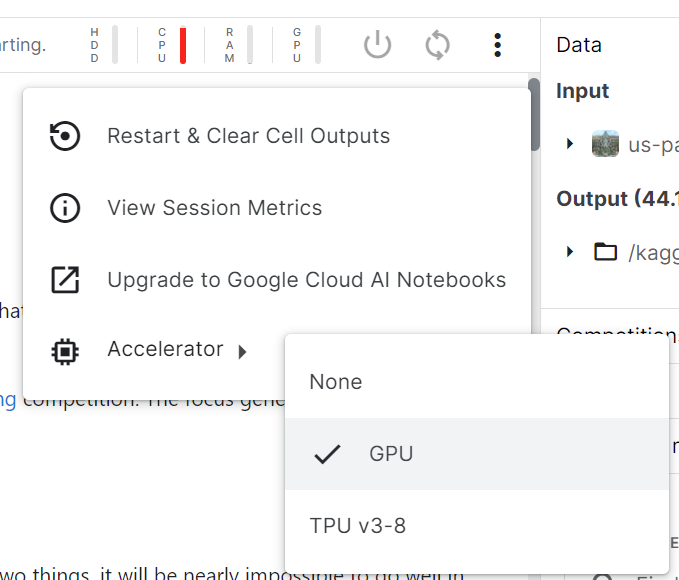!

We'll need slightly different code depending on whether we're running on Kaggle or not, so we'll use this variable to track where we are:

In [1]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

### Using Kaggle data on your own machine

Kaggle limits your weekly time using a GPU machine. The limits are very generous, but you may well still find it's not enough! In that case, you'll want to use your own GPU server, or a cloud server such as Colab, Paperspace Gradient, or SageMaker Studio Lab (all of which have free options). To do so, you'll need to be able to download Kaggle datasets.

The easiest way to download Kaggle datasets is to use the Kaggle API. You can install this using `pip` by running this in a notebook cell:

    !pip install kaggle

You need an API key to use the Kaggle API; to get one, click on your profile picture on the Kaggle website, and choose My Account, then click Create New API Token. This will save a file called *kaggle.json* to your PC. You need to copy this key on your GPU server. To do so, open the file you downloaded, copy the contents, and paste them in the following cell (e.g., `creds = '{"username":"xxx","key":"xxx"}'`):

In [2]:
creds = '{"username":"gkhanelbistan","key":"2aef6919726e969adf4cd9832d0f18e5"}'

Then execute this cell (this only needs to be run once):

In [3]:
# for working with paths in Python, I recommend using `pathlib.Path`
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

Now you can download datasets from Kaggle.

In [4]:
path = Path('us-patent-phrase-to-phrase-matching')

And use the Kaggle API to download the dataset to that path, and extract it:

In [5]:
if not iskaggle and not path.exists():
    import zipfile,kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

Note that you can easily download notebooks from Kaggle and upload them to other cloud services. So if you're low on Kaggle GPU credits, give this a try!

## Import and EDA

In [6]:
if iskaggle:
    path = Path('../input/us-patent-phrase-to-phrase-matching')
    !pip install -q datasets

Documents in NLP datasets are generally in one of two main forms:

- **Larger documents**: One text file per document, often organised into one folder per category
- **Smaller documents**: One document (or document pair, optionally with metadata) per row in a [CSV file](https://realpython.com/python-csv/).

Let's look at our data and see what we've got. In Jupyter you can use any bash/shell command by starting a line with a `!`, and use `{}` to include python variables, like so:

In [7]:
!ls {path}

'ls' is not recognized as an internal or external command,
operable program or batch file.


It looks like this competition uses CSV files. For opening, manipulating, and viewing CSV files, it's generally best to use the Pandas library, which is explained brilliantly in [this book](https://wesmckinney.com/book/) by the lead developer (it's also an excellent introduction to matplotlib and numpy, both of which I use in this notebook). Generally it's imported as the abbreviation `pd`.

In [8]:
import pandas as pd

Let's set a path to our data:

In [9]:
df = pd.read_csv(path/'train.csv')

This creates a [DataFrame](https://pandas.pydata.org/docs/user_guide/10min.html), which is a table of named columns, a bit like a database table. To view the first and last rows, and row count of a DataFrame, just type its name:

In [10]:
df

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


It's important to carefully read the [dataset description](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/data) to understand how each of these columns is used.

One of the most useful features of `DataFrame` is the `describe()` method:

In [11]:
df.describe(include='object')

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,37d61fd2272659b1,component composite coating,composition,H01
freq,1,152,24,2186


We can see that in the 36473 rows, there are 733 unique anchors, 106 contexts, and nearly 30000 targets. Some anchors are very common, with "component composite coating" for instance appearing 152 times.

Earlier, I suggested we could represent the input to the model as something like "*TEXT1: abatement; TEXT2: eliminating process*". We'll need to add the context to this too. In Pandas, we just use `+` to concatenate, like so:

In [12]:
df['input'] = 'TEXT1: ' + df.context + '; TEXT2: ' + df.target + '; ANC1: ' + df.anchor

We can refer to a column (also known as a *series*) either using regular python "dotted" notation, or access it like a dictionary. To get the first few rows, use `head()`:

In [13]:
df.input.head()

0    TEXT1: A47; TEXT2: abatement of pollution; ANC...
1    TEXT1: A47; TEXT2: act of abating; ANC1: abate...
2    TEXT1: A47; TEXT2: active catalyst; ANC1: abat...
3    TEXT1: A47; TEXT2: eliminating process; ANC1: ...
4    TEXT1: A47; TEXT2: forest region; ANC1: abatement
Name: input, dtype: object

## Tokenization

Transformers uses a `Dataset` object for storing a... well a dataset, of course! We can create one like so:

In [25]:
%pip install datasets
from datasets import Dataset, DatasetDict


ds = Dataset.from_pandas(df)


  Using cached datasets-2.19.1-py3-none-any.whl.metadata (19 kB)
  Using cached pyarrow_hotfix-0.6-py3-none-any.whl.metadata (3.6 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ------- -------------------------------- 10.2/57.6 kB ? eta -:--:--
     -------------------- ----------------- 30.7/57.6 kB 330.3 kB/s eta 0:00:01
     -------------------------------------- 57.6/57.6 kB 434.1 kB/s eta 0:00:00
  Using cached huggingface_hub-0.23.0-py3-none-any.whl.metadata (12 kB)
  Using cached attrs-23.2.0-py3-none-any.whl.metadata (9.5 kB)
Using cached datasets-2.19.1-py3-none-any.whl (542 kB)
Using cached dill-0.3.8-py3-none-any.whl (116 kB)
   ---------------------------------------- 0.0/172.0 kB ? eta -:--:--
   ---------------- ----------------------- 71.7/172.0 kB 2.0 MB/s eta 0:00:01
   ---------------------------- ----------- 122.9/172.0 kB 1.4 MB/s eta 0:00:01
   ---------------------------

C:\Users\gokhan.elbistan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Here's how it's displayed in a notebook:

In [26]:
ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input'],
    num_rows: 36473
})

But we can't pass the texts directly into a model. A deep learning model expects numbers as inputs, not English sentences! So we need to do two things:

- *Tokenization*: Split each text up into words (or actually, as we'll see, into *tokens*)
- *Numericalization*: Convert each word (or token) into a number.

The details about how this is done actually depend on the particular model we use. So first we'll need to pick a model. There are thousands of models available, but a reasonable starting point for nearly any NLP problem is to use this (replace "small" with "large" for a slower but more accurate model, once you've finished exploring):

In [27]:
model_nm = 'google-bert/bert-base-uncased'

`AutoTokenizer` will create a tokenizer appropriate for a given model:

In [30]:
%pip install transformers
from transformers import AutoModelForSequenceClassification,AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm)

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


  Using cached transformers-4.40.2-py3-none-any.whl.metadata (137 kB)
     ---------------------------------------- 0.0/42.0 kB ? eta -:--:--
     ------------------ ------------------- 20.5/42.0 kB 682.7 kB/s eta 0:00:01
     ------------------ ------------------- 20.5/42.0 kB 682.7 kB/s eta 0:00:01
     --------------------------- ---------- 30.7/42.0 kB 262.6 kB/s eta 0:00:01
     --------------------------- ---------- 30.7/42.0 kB 262.6 kB/s eta 0:00:01
     --------------------------- ---------- 30.7/42.0 kB 262.6 kB/s eta 0:00:01
     --------------------------- ---------- 30.7/42.0 kB 262.6 kB/s eta 0:00:01
     -------------------------------------  41.0/42.0 kB 103.4 kB/s eta 0:00:01
     -------------------------------------- 42.0/42.0 kB 106.8 kB/s eta 0:00:00
Using cached transformers-4.40.2-py3-none-any.whl (9.0 MB)
   ---------------------------------------- 0.0/269.0 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/269.0 kB 660.6 kB/s eta 0:00:01
   -----

C:\Users\gokhan.elbistan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Here's an example of how the tokenizer splits a text into "tokens" (which are like words, but can be sub-word pieces, as you see below):

In [31]:
tokz.tokenize("G'day folks, I'm Jeremy from fast.ai!")

['g',
 "'",
 'day',
 'folks',
 ',',
 'i',
 "'",
 'm',
 'jeremy',
 'from',
 'fast',
 '.',
 'ai',
 '!']

Uncommon words will be split into pieces. The start of a new word is represented by `▁`:

In [32]:
tokz.tokenize("A platypus is an ornithorhynchus anatinus.")

['a',
 'pl',
 '##at',
 '##yp',
 '##us',
 'is',
 'an',
 'or',
 '##ni',
 '##thor',
 '##hy',
 '##nch',
 '##us',
 'ana',
 '##tin',
 '##us',
 '.']

Here's a simple function which tokenizes our inputs:

In [ ]:
def tok_func(x): return tokz(x["input"])

To run this quickly in parallel on every row in our dataset, use `map`:

In [ ]:
tok_ds = ds.map(tok_func, batched=True)

Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

This adds a new item to our dataset called `input_ids`. For instance, here is the input and IDs for the first row of our data:

In [ ]:
row = tok_ds[0]
row['input'], row['input_ids']

('TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement',
 [101,
  3793,
  2487,
  1024,
  1037,
  22610,
  1025,
  3793,
  2475,
  1024,
  19557,
  18532,
  4765,
  1997,
  10796,
  1025,
  2019,
  2278,
  2487,
  1024,
  19557,
  18532,
  4765,
  102])

So, what are those IDs and where do they come from? The secret is that there's a list called `vocab` in the tokenizer which contains a unique integer for every possible token string. We can look them up like this, for instance to find the token for the word "of":

In [33]:
tokz.vocab['▁of']

KeyError: '▁of'

Looking above at our input IDs, we do indeed see that `265` appears as expected.

Finally, we need to prepare our labels. Transformers always assumes that your labels has the column name `labels`, but in our dataset it's currently `score`. Therefore, we need to rename it:

In [ ]:
tok_ds = tok_ds.rename_columns({'score':'labels'})

Now that we've prepared our tokens and labels, we need to create our validation set.

## Test and validation sets

You may have noticed that our directory contained another file:

In [ ]:
eval_df = pd.read_csv(path/'test.csv')
eval_df.describe()

,id,anchor,target,context
count,36,36,36,36
unique,36,34,36,29
top,4112d61851461f60,el display,inorganic photoconductor drum,G02
freq,1,2,1,3


This is the *test set*. Possibly the most important idea in machine learning is that of having separate training, validation, and test data sets.

### Validation set

To explain the motivation, let's start simple, and imagine we're trying to fit a model where the true relationship is this quadratic:

In [ ]:
def f(x): return -3*x**2 + 2*x + 20

Unfortunately matplotlib (the most common library for plotting in Python) doesn't come with a way to visualize a function, so we'll write something to do this ourselves:

In [ ]:
import numpy as np, matplotlib.pyplot as plt

def plot_function(f, min=-2.1, max=2.1, color='r'):
    x = np.linspace(min,max, 100)[:,None]
    plt.plot(x, f(x), color)

Here's what our function looks like:

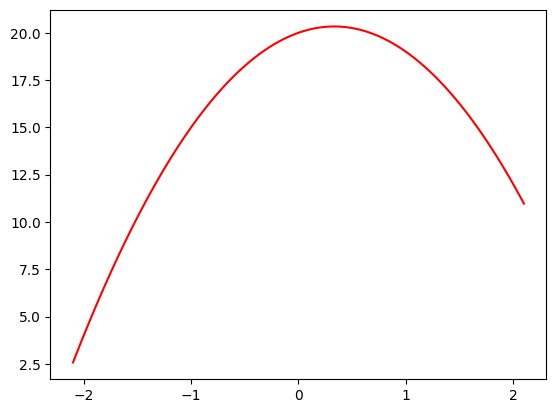

In [ ]:
plot_function(f)

For instance, perhaps we've measured the height above ground of an object before and after some event. The measurements will have some random error. We can use numpy's random number generator to simulate that. I like to use `seed` when writing about simulations like this so that I know you'll see the same thing I do:

In [ ]:
from numpy.random import normal,seed,uniform
np.random.seed(42)

Here's a function `add_noise` that adds some random variation to an array:

In [ ]:
def noise(x, scale): return normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)

Let's use it to simulate some measurements evenly distributed over time:

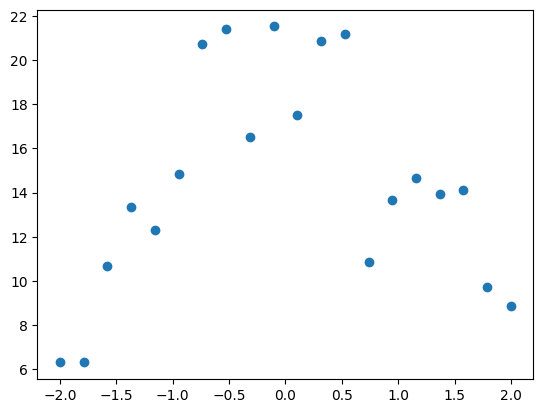

In [ ]:
x = np.linspace(-2, 2, num=20)[:,None]
y = add_noise(f(x), 0.2, 1.3)
plt.scatter(x,y);

Now let's see what happens if we *underfit* or *overfit* these predictions. To do that, we'll create a function that fits a polynomial of some degree (e.g. a line is degree 1, quadratic is degree 2, cubic is degree 3, etc). The details of how this function works don't matter too much so feel free to skip over it if you like!  (PS: if you're not sure about the jargon around polynomials, here's a [great video](https://www.youtube.com/watch?v=ffLLmV4mZwU) which teaches you what you'll need to know.)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def plot_poly(degree):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(x, y)
    plt.scatter(x,y)
    plot_function(model.predict)

So, what happens if we fit a line (a "degree 1 polynomial") to our measurements?

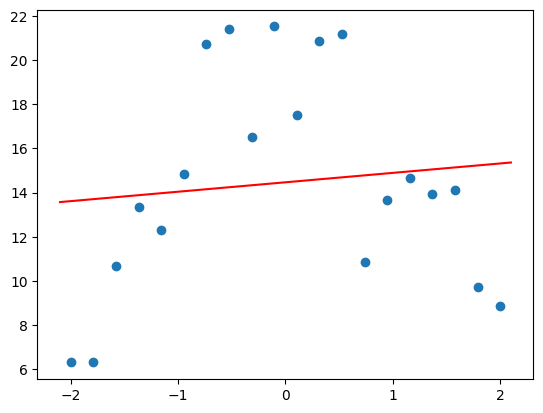

In [ ]:
plot_poly(1)

As you see, the points on the red line (the line we fitted) aren't very close at all. This is *under-fit* -- there's not enough detail in our function to match our data.

And what happens if we fit a degree 10 polynomial to our measurements?

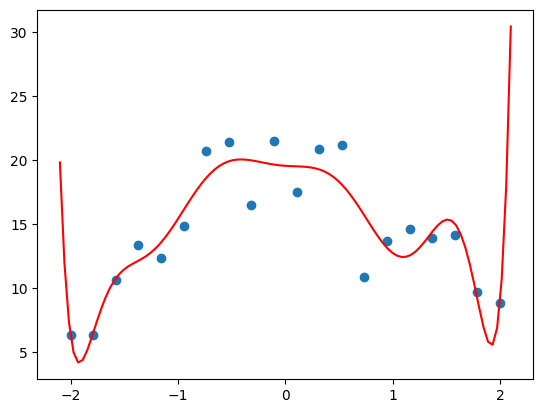

In [ ]:
plot_poly(10)

Well now it fits our data better, but it doesn't look like it'll do a great job predicting points other than those we measured -- especially those in earlier or later time periods. This is *over-fit* -- there's too much detail such that the model fits our points, but not the underlying process we really care about.

Let's try a degree 2 polynomial (a quadratic), and compare it to our "true" function (in blue):

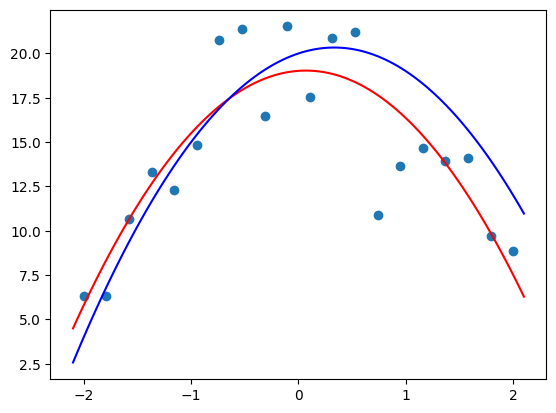

In [ ]:
plot_poly(2)
plot_function(f, color='b')

That's not bad at all!

So, how do we recognise whether our models are under-fit, over-fit, or "just right"? We use a *validation set*. This is a set of data that we "hold out" from training -- we don't let our model see it at all. If you use the fastai library, it automatically creates a validation set for you if you don't have one, and will always report metrics (measurements of the accuracy of a model) using the validation set.

The validation set is *only* ever used to see how we're doing. It's *never* used as inputs to training the model.

Transformers uses a `DatasetDict` for holding your training and validation sets. To create one that contains 25% of our data for the validation set, and 75% for the training set, use `train_test_split`:

In [ ]:
dds = tok_ds.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})

As you see above, the validation set here is called `test` and not `validate`, so be careful!

In practice, a random split like we've used here might not be a good idea -- here's what Dr Rachel Thomas has to say about it:

> "*One of the most likely culprits for this disconnect between results in development vs results in production is a poorly chosen validation set (or even worse, no validation set at all). Depending on the nature of your data, choosing a validation set can be the most important step. Although sklearn offers a `train_test_split` method, this method takes a random subset of the data, which is a poor choice for many real-world problems.*"

I strongly recommend reading her article [How (and why) to create a good validation set](https://www.fast.ai/2017/11/13/validation-sets/) to more fully understand this critical topic.

### Test set

So that's the validation set explained, and created. What about the "test set" then -- what's that for?

The *test set* is yet another dataset that's held out from training. But it's held out from reporting metrics too! The accuracy of your model on the test set is only ever checked after you've completed your entire training process, including trying different models, training methods, data processing, etc.

You see, as you try all these different things, to see their impact on the metrics on the validation set, you might just accidentally find a few things that entirely coincidentally improve your validation set metrics, but aren't really better in practice. Given enough time and experiments, you'll find lots of these coincidental improvements. That means you're actually over-fitting to your validation set!

That's why we keep a test set held back. Kaggle's public leaderboard is like a test set that you can check from time to time. But don't check too often, or you'll be even over-fitting to the test set!

Kaggle has a *second* test set, which is yet another held-out dataset that's only used at the *end* of the competition to assess your predictions. That's called the "private leaderboard". Here's a [great post](https://gregpark.io/blog/Kaggle-Psychopathy-Postmortem/) about what can happen if you overfit to the public leaderboard.

We'll use `eval` as our name for the test set, to avoid confusion with the `test` dataset that was created above.

In [ ]:
eval_df['input'] = 'TEXT1: ' + eval_df.context + '; TEXT2: ' + eval_df.target + '; ANC1: ' + eval_df.anchor
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

## Metrics and correlation

When we're training a model, there will be one or more *metrics* that we're interested in maximising or minimising. These are the measurements that should, hopefully, represent how well our model will works for us.

In real life, outside of Kaggle, things not easy... As my partner Dr Rachel Thomas notes in [The problem with metrics is a big problem for AI](https://www.fast.ai/2019/09/24/metrics/):

>  At their heart, what most current AI approaches do is to optimize metrics. The practice of optimizing metrics is not new nor unique to AI, yet AI can be particularly efficient (even too efficient!) at doing so. This is important to understand, because any risks of optimizing metrics are heightened by AI. While metrics can be useful in their proper place, there are harms when they are unthinkingly applied. Some of the scariest instances of algorithms run amok all result from over-emphasizing metrics. We have to understand this dynamic in order to understand the urgent risks we are facing due to misuse of AI.

In Kaggle, however, it's very straightforward to know what metric to use: Kaggle will tell you! According to this competition's [evaluation page](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/overview/evaluation), "*submissions are evaluated on the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) between the predicted and actual similarity scores*." This coefficient is usually abbreviated using the single letter *r*. It is the most widely used measure of the degree of relationship between two variables.

r can vary between `-1`, which means perfect inverse correlation, and `+1`, which means perfect positive correlation. The mathematical formula for it is much less important than getting a good intuition for what the different values look like. To start to get that intuition, let's look at some examples using the [California Housing](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset) dataset, which shows "*is the median house value for California districts, expressed in hundreds of thousands of dollars*". This dataset is provided by the excellent [scikit-learn](https://scikit-learn.org/stable/) library, which is the most widely used library for machine learning outside of deep learning.

In [ ]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing(as_frame=True)
housing = housing['data'].join(housing['target']).sample(1000, random_state=52)
housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
7506,3.0550,37.0,5.152778,1.048611,729.0,5.062500,33.92,-118.28,1.054
4720,3.0862,35.0,4.697897,1.055449,1159.0,2.216061,34.05,-118.37,3.453
12888,2.5556,24.0,4.864905,1.129222,1631.0,2.395007,38.66,-121.35,1.057
13344,3.0057,32.0,4.212687,0.936567,1378.0,5.141791,34.05,-117.64,0.969
7173,1.9083,42.0,3.888554,1.039157,1535.0,4.623494,34.05,-118.19,1.192


We can see all the correlation coefficients for every combination of columns in this dataset by calling `np.corrcoef`:

In [ ]:
np.set_printoptions(precision=2, suppress=True)

np.corrcoef(housing, rowvar=False)

array([[ 1.  , -0.12,  0.43, -0.08,  0.01, -0.07, -0.12,  0.04,  0.68],
       [-0.12,  1.  , -0.17, -0.06, -0.31,  0.  ,  0.03, -0.13,  0.12],
       [ 0.43, -0.17,  1.  ,  0.76, -0.09, -0.07,  0.12, -0.03,  0.21],
       [-0.08, -0.06,  0.76,  1.  , -0.08, -0.07,  0.09,  0.  , -0.04],
       [ 0.01, -0.31, -0.09, -0.08,  1.  ,  0.16, -0.15,  0.13,  0.  ],
       [-0.07,  0.  , -0.07, -0.07,  0.16,  1.  , -0.16,  0.17, -0.27],
       [-0.12,  0.03,  0.12,  0.09, -0.15, -0.16,  1.  , -0.93, -0.16],
       [ 0.04, -0.13, -0.03,  0.  ,  0.13,  0.17, -0.93,  1.  , -0.03],
       [ 0.68,  0.12,  0.21, -0.04,  0.  , -0.27, -0.16, -0.03,  1.  ]])

This works well when we're getting a bunch of values at once, but it's overkill when we want a single coefficient:

In [ ]:
np.corrcoef(housing.MedInc, housing.MedHouseVal)

array([[1.  , 0.68],
       [0.68, 1.  ]])

Therefore, we'll create this little function to just return the single number we need given a pair of variables:

In [ ]:
def corr(x,y): return np.corrcoef(x,y)[0][1]

corr(housing.MedInc, housing.MedHouseVal)

0.6760250732906

Now we'll look at a few examples of correlations, using this function (the details of the function don't matter too much):

In [ ]:
def show_corr(df, a, b):
    x,y = df[a],df[b]
    plt.scatter(x,y, alpha=0.5, s=4)
    plt.title(f'{a} vs {b}; r: {corr(x, y):.2f}')

OK, let's check out the correlation between income and house value:

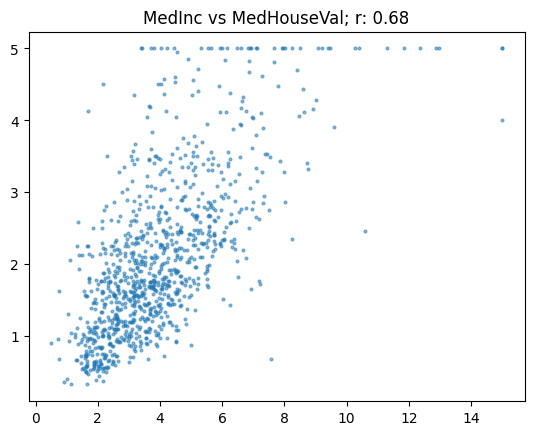

In [ ]:
show_corr(housing, 'MedInc', 'MedHouseVal')

So that's what a correlation of 0.68 looks like. It's quite a close relationship, but there's still a lot of variation. (Incidentally, this also shows why looking at your data is so important -- we can see clearly in this plot that house prices above $500,000 seem to have been truncated to that maximum value).

Let's take a look at another pair:

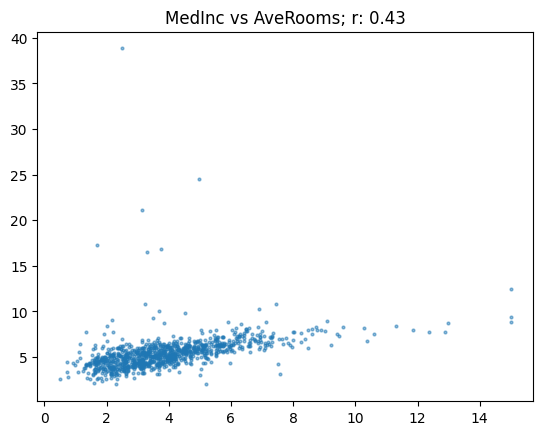

In [ ]:
show_corr(housing, 'MedInc', 'AveRooms')

The relationship looks like it is similarly close to the previous example, but r is much lower than the income vs valuation case. Why is that? The reason is that there are a lot of *outliers* -- values of `AveRooms` well outside the mean.

r is very sensitive to outliers. If there's outliers in your data, then the relationship between them will dominate the metric. In this case, the houses with a very high number of rooms don't tend to be that valuable, so it's decreasing r from where it would otherwise be.

Let's remove the outliers and try again:

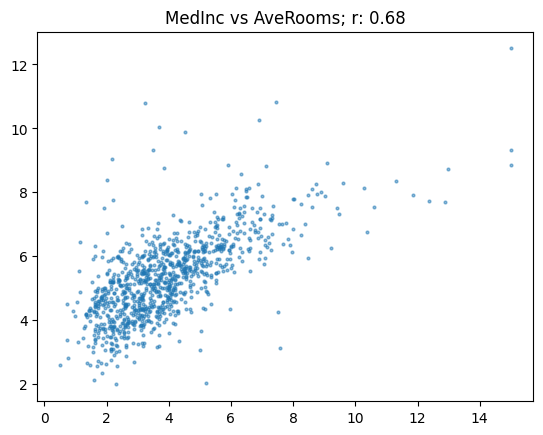

In [ ]:
subset = housing[housing.AveRooms<15]
show_corr(subset, 'MedInc', 'AveRooms')

As we expected, now the correlation is very similar to our first comparison.

Here's another relationship using `AveRooms` on the subset:

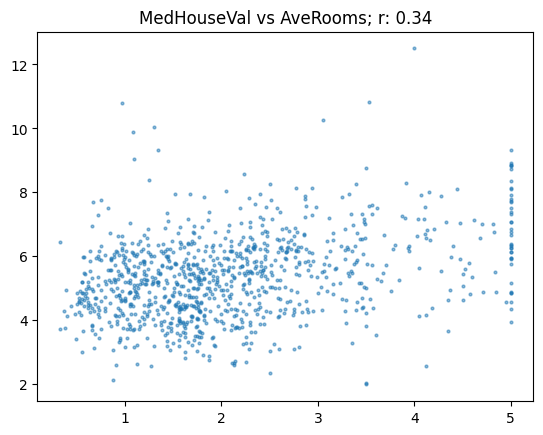

In [ ]:
show_corr(subset, 'MedHouseVal', 'AveRooms')

At this level, with r of 0.34, the relationship is becoming quite weak.

Let's look at one more:

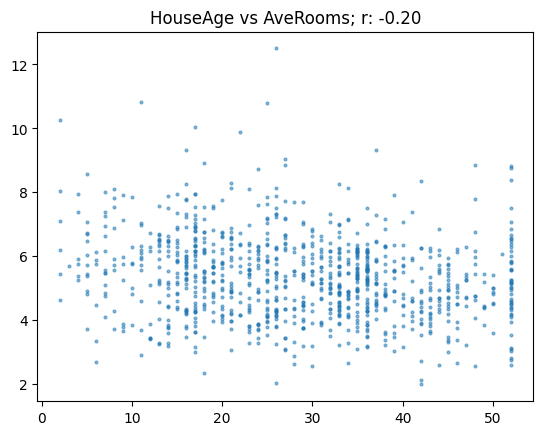

In [ ]:
show_corr(subset, 'HouseAge', 'AveRooms')

As you see here, a correlation of -0.2 shows a very weak negative trend.

We've seen now examples of a variety of levels of correlation coefficient, so hopefully you're getting a good sense of what this metric means.

Transformers expects metrics to be returned as a `dict`, since that way the trainer knows what label to use, so let's create a function to do that:

In [ ]:
def corr_d(eval_pred):
    return {'pearson': corr(*eval_pred)}

## Training

## Training our model

To train a model in Transformers we'll need this:

In [34]:
from transformers import TrainingArguments,Trainer

We pick a batch size that fits our GPU, and small number of epochs so we can run experiments quickly:

In [35]:
bs = 128
epochs = 4

The most important hyperparameter is the learning rate. fastai provides a learning rate finder to help you figure this out, but Transformers doesn't, so you'll just have to use trial and error. The idea is to find the largest value you can, but which doesn't result in training failing.

In [36]:
lr = 8e-5

Transformers uses the `TrainingArguments` class to set up arguments. Don't worry too much about the values we're using here -- they should generally work fine in most cases. It's just the 3 parameters above that you may need to change for different models.

In [37]:
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=0.01, report_to='none')

We can now create our model, and `Trainer`, which is a class which combines the data and model together (just like `Learner` in fastai):

In [38]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                  tokenizer=tokz, compute_metrics=corr_d)

ImportError: 
AutoModelForSequenceClassification requires the PyTorch library but it was not found in your environment. Checkout the instructions on the
installation page: https://pytorch.org/get-started/locally/ and follow the ones that match your environment.
Please note that you may need to restart your runtime after installation.


As you see, Transformers spits out lots of warnings. You can safely ignore them.

Let's train our model!

In [ ]:
trainer.train();

The following columns in the training set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: context, id, target, anchor, input.
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 27354
  Num Epochs = 4
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 856
/opt/conda/lib/python3.7/site-packages/transformers/trainer.py:1410: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-fin

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.024492,0.800443
2,No log,0.022003,0.826113
3,0.041600,0.021423,0.834453
4,0.041600,0.022275,0.834767


The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: context, id, target, anchor, input.
***** Running Evaluation *****
  Num examples = 9119
  Batch size = 256
The following columns in the evaluation set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: context, id, target, anchor, input.
***** Running Evaluation *****
  Num examples = 9119
  Batch size = 256
Saving model checkpoint to outputs/checkpoint-500
Configuration saved in outputs/checkpoint-500/config.json
Model weights saved in outputs/checkpoint-500/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-500/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-500/special_tokens_map.json
added tokens file saved in outputs/checkpoint-500/added_tokens.json
The following columns in the evaluation set  don't have a corresponding argument in `Deb

Lots more warning from Transformers again -- you can ignore these as before.

The key thing to look at is the "Pearson" value in table above. As you see, it's increasing, and is already above 0.8. That's great news! We can now submit our predictions to Kaggle if we want them to be scored on the official leaderboard. Let's get some predictions on the test set:

In [ ]:
preds = trainer.predict(eval_ds).predictions.astype(float)
preds

The following columns in the test set  don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: context, id, target, anchor, input.
***** Running Prediction *****
  Num examples = 36
  Batch size = 256


array([[ 0.51],
       [ 0.65],
       [ 0.5 ],
       [ 0.32],
       [-0.04],
       [ 0.52],
       [ 0.52],
       [ 0.07],
       [ 0.28],
       [ 1.11],
       [ 0.25],
       [ 0.22],
       [ 0.71],
       [ 0.88],
       [ 0.73],
       [ 0.41],
       [ 0.33],
       [ 0.  ],
       [ 0.69],
       [ 0.35],
       [ 0.4 ],
       [ 0.25],
       [ 0.12],
       [ 0.27],
       [ 0.56],
       [-0.  ],
       [-0.03],
       [-0.01],
       [-0.03],
       [ 0.59],
       [ 0.29],
       [ 0.03],
       [ 0.74],
       [ 0.57],
       [ 0.46],
       [ 0.21]])

Look out - some of our predictions are <0, or >1! This once again shows the value of remember to actually *look* at your data. Let's fix those out-of-bounds predictions:

In [ ]:
preds = np.clip(preds, 0, 1)

In [ ]:
preds

array([[0.51],
       [0.65],
       [0.5 ],
       [0.32],
       [0.  ],
       [0.52],
       [0.52],
       [0.07],
       [0.28],
       [1.  ],
       [0.25],
       [0.22],
       [0.71],
       [0.88],
       [0.73],
       [0.41],
       [0.33],
       [0.  ],
       [0.69],
       [0.35],
       [0.4 ],
       [0.25],
       [0.12],
       [0.27],
       [0.56],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.59],
       [0.29],
       [0.03],
       [0.74],
       [0.57],
       [0.46],
       [0.21]])

OK, now we're ready to create our submission file. If you save a CSV in your notebook, you will get the option to submit it later.

In [ ]:
import datasets

submission = datasets.Dataset.from_dict({
    'id': eval_ds['id'],
    'score': preds
})

submission.to_csv('submission.csv', index=False)

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

857

Unfortunately this is a *code competition* and internet access is disabled. That means the `pip install datasets` command we used above won't work if you want to submit to Kaggle. To fix this, you'll need to download the pip installers to Kaggle first, as [described here](https://www.kaggle.com/c/severstal-steel-defect-detection/discussion/113195). Once you've done that, disable internet in your notebook, go to the Kaggle leaderboards page, and click the *Submission* button.

## The end

Once you're ready to go deeper, take a look at my [Iterate Like a Grandmaster](https://www.kaggle.com/code/jhoward/iterate-like-a-grandmaster/) notebook.

Thanks for reading! This has been a bit of an experiment for me -- I've never done an "absolute beginners" guide before on Kaggle. I hope you like it! If you do, I'd greatly appreciate an upvote. Don't hesitate to add a comment if you have any questions or thoughts to add.